In [ ]:
!pip install pycuda

In [ ]:
import numpy as np

from scipy import interpolate

import matplotlib.pyplot as plt

import random

In [ ]:
# --- PyCUDA initialization
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray

In [ ]:
def nearestNeighborInterpolation1D(x, y, xi):

  # --- NOTE: Input sample spacing must be uniform

  # --- Forces vectors to be columns
  np.reshape(x, (len(x), 1))
  np.reshape(xi, (len(xi), 1))
  np.reshape(y, (len(y), 1))

  # --- Gets the x spacing. One over to perform divide only once
  ndx   = 1 / (x[1] - x[0])

  # --- Subtract minimum of x from xi
  xi    = xi - x[0]

  # --- Fills output with NaNs
  yi    = float('nan') * np.ones_like(xi)

  # --- Indices of nearest-neighbors
  rxi   = np.round(xi * ndx)

  # --- Finds in-bound indices
  flag  = np.where((rxi >= 0) & (rxi <= (len(x) - 1)))

  yi[flag] = y[np.int32(rxi[flag])]

  return yi

In [ ]:
def linearInterpolation1D(x, y, xi):

  # --- Forces vectors to be columns
  np.reshape(x, (len(x), 1))
  np.reshape(xi, (len(xi), 1))
  np.reshape(y, (len(y), 1))

  # --- Gets the x spacing. One over to perform divide only once
  ndx   = 1 / (x[1] - x[0])

  # --- Subtract minimum of x from xi
  xi    = xi - x[0]

  # --- Fills output with NaNs
  yi    = float('nan') * np.ones_like(xi)

  # --- Indices of nearest-lower-neighbors
  fxi   = np.floor(xi * ndx)

  # --- Finds out of bounds indices
  flag  = np.where((fxi >= 0) & (fxi <= (len(x) - 2)))

  yi[flag] = -(xi[flag] * ndx - (fxi[flag] + 1)) * y[np.int32(fxi[flag])] + (xi[flag] * ndx - (fxi[flag])) * y[np.int32(fxi[flag]) + 1]

  return yi

In [ ]:
BLOCKSIZE   = 256

###################
# iDivUp FUNCTION #
###################
def iDivUp(a, b):
    return a // b + 1

###############################
# LINEAR INTERPOLATION ON GPU #
###############################
mod = SourceModule("""

__device__ __constant__ float ndx_const;

texture<float, 1> d_yintexture;
texture<float, 1> d_yintexture_filtering;

__global__ void linear_interpolation_kernel_function_GPU(const float* __restrict__ d_xin, const float* __restrict__ d_yin, float * __restrict__ d_xout, float* __restrict__ d_yout, const int N, const int M) {

  int j = threadIdx.x + blockDim.x * blockIdx.x;

  if (j < M) {

    //float     ndx       = 1.f / (d_xin[1] - d_xin[0]);
    float     xi        = d_xout[j] - d_xin[0];
    int       fxi       = __float2int_rz(xi * ndx_const);
    float     dk        = d_yin[fxi];
    float     dkp1      = d_yin[fxi + 1];
    float     a         = xi * ndx_const - truncf(xi * ndx_const);
    d_yout[j]           = -(a - 1.f) * dk + a * dkp1; }}

__global__ void linear_interpolation_kernel_function_GPU_texture(const float* __restrict__ d_xin, float * __restrict__ d_xout, float* __restrict__ d_yout, const int N, const int M) {

  int j = threadIdx.x + blockDim.x * blockIdx.x;

  if (j < M) {

    //float     ndx       = 1.f / (d_xin[1] - d_xin[0]);
    float     xi        = d_xout[j] - d_xin[0];
    int       fxi       = __float2int_rz(xi * ndx_const);
    float     dk        = tex1Dfetch(d_yintexture, fxi);
    float     dkp1      = tex1Dfetch(d_yintexture, fxi + 1);
    float     a         = xi * ndx_const - truncf(xi * ndx_const);
    d_yout[j]           = -(a - 1.f) * dk + a * dkp1; }}

__global__ void linear_interpolation_kernel_function_GPU_texture_filtering(const float* __restrict__ d_xin, float * __restrict__ d_xout, float* __restrict__ d_yout, const int N, const int M) {

  int j = threadIdx.x + blockDim.x * blockIdx.x;

  if (j < N) {

    float     xi        = (d_xout[j] - d_xin[0]) * ndx_const;

    d_yout[j] = tex1D(d_yintexture_filtering, (float)xi + 0.5f); }}

    """)

# --- Define a reference to the __global__ function and call it
linear_interpolation_kernel_function_GPU                    = mod.get_function("linear_interpolation_kernel_function_GPU")
linear_interpolation_kernel_function_GPU_texture            = mod.get_function("linear_interpolation_kernel_function_GPU_texture")
linear_interpolation_kernel_function_GPU_texture_filtering  = mod.get_function("linear_interpolation_kernel_function_GPU_texture_filtering")

def linear_interpolation_function_GPU(d_xin, d_yin, d_xout, d_yout, ndx, N, M):

  ndx1      = np.array(ndx)
  ndx_ref,_ = mod.get_global("ndx_const")
  cuda.memcpy_htod(ndx_ref, ndx1)

  blockDim                                  = (BLOCKSIZE, 1, 1)
  gridDim                                   = (iDivUp(N, BLOCKSIZE), 1, 1)
  linear_interpolation_kernel_function_GPU(d_xin, d_yin, d_xout, d_yout, np.int32(N), np.int32(M), block = blockDim, grid = gridDim)

def linear_interpolation_function_GPU_texture(d_xin, d_yin, d_xout, d_yout, ndx, N, M):

  ndx1      = np.array(ndx)
  ndx_ref,_ = mod.get_global("ndx_const")
  cuda.memcpy_htod(ndx_ref, ndx1)

  d_yintexture = mod.get_texref('d_yintexture')

  d_yin.bind_to_texref(d_yintexture)

  blockDim                                  = (BLOCKSIZE, 1, 1)
  gridDim                                   = (iDivUp(N, BLOCKSIZE), 1, 1)
  linear_interpolation_kernel_function_GPU_texture(d_xin, d_xout, d_yout, np.int32(N), np.int32(M), block = blockDim, grid = gridDim)

def linear_interpolation_function_GPU_texture_filtering(d_xin, yin, d_xout, d_yout, ndx, N, M):

  ndx1      = np.array(ndx)
  ndx_ref,_ = mod.get_global("ndx_const")
  cuda.memcpy_htod(ndx_ref, ndx1)

  d_yintexture_filtering = mod.get_texref('d_yintexture_filtering')

  d_yin2 = cuda.matrix_to_array(yin, order='C')
  cuda.bind_array_to_texref(d_yin2, d_yintexture_filtering)

  d_yintexture_filtering.set_flags(cuda.TRSF_READ_AS_INTEGER)
  d_yintexture_filtering.set_filter_mode(cuda.filter_mode.LINEAR)

  blockDim                                  = (BLOCKSIZE, 1, 1)
  gridDim                                   = (iDivUp(N, BLOCKSIZE), 1, 1)
  linear_interpolation_kernel_function_GPU_texture_filtering(d_xin, d_xout, d_yout, np.int32(N), np.int32(M), block = blockDim, grid = gridDim)

def nearest_interpolation_function_GPU_texture_filtering(d_xin, yin, d_xout, d_yout, ndx, N, M):

  ndx1      = np.array(ndx)
  ndx_ref,_ = mod.get_global("ndx_const")
  cuda.memcpy_htod(ndx_ref, ndx1)

  d_yintexture_filtering = mod.get_texref('d_yintexture_filtering')

  d_yin2 = cuda.matrix_to_array(yin, order='C')
  cuda.bind_array_to_texref(d_yin2, d_yintexture_filtering)

  d_yintexture_filtering.set_flags(cuda.TRSF_READ_AS_INTEGER)
  d_yintexture_filtering.set_filter_mode(cuda.filter_mode.POINT)

  blockDim                                  = (BLOCKSIZE, 1, 1)
  gridDim                                   = (iDivUp(N, BLOCKSIZE), 1, 1)
  linear_interpolation_kernel_function_GPU_texture_filtering(d_xin, d_xout, d_yout, np.int32(N), np.int32(M), block = blockDim, grid = gridDim)

Root mean square for nearest neighbor interpolation on CPU 0.000000


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()
/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


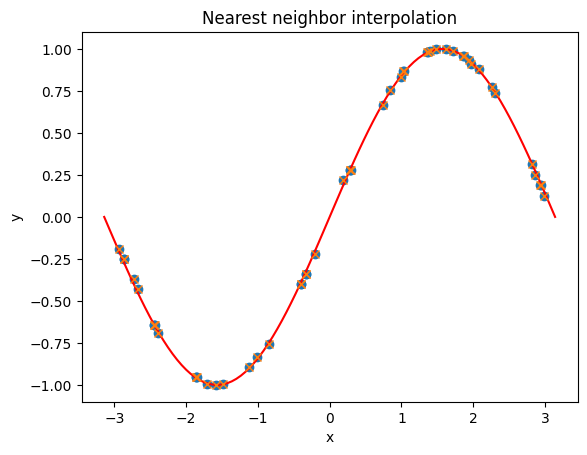

Root mean square for linear interpolation on CPU 0.000036


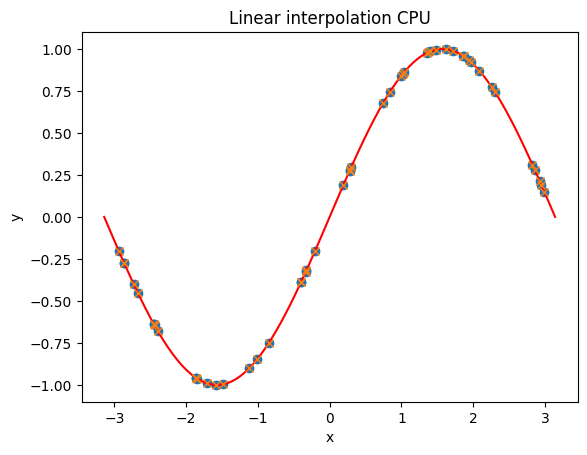

Root mean square for linear interpolation on GPU 0.000036


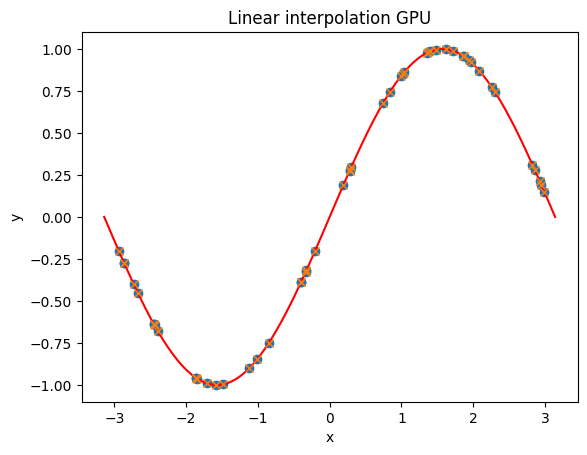

Root mean square for linear interpolation on GPU (texture) 0.000036


/usr/local/lib/python3.10/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: device_allocation in out-of-thread context could not be cleaned up
  globals().clear()


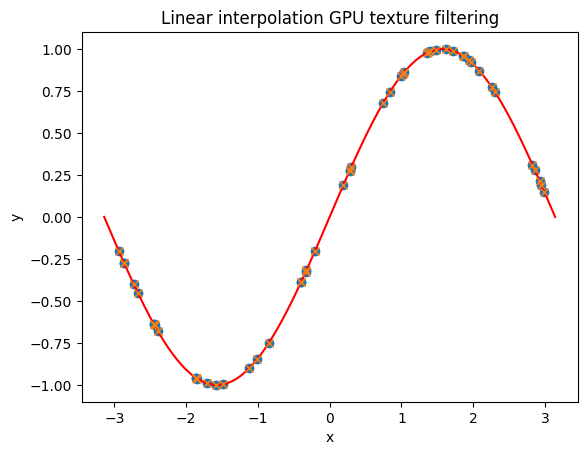

Root mean square for linear interpolation on GPU (texture) 0.001398


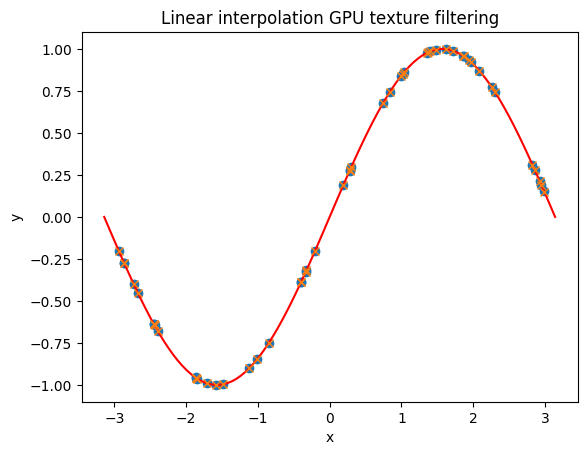

Root mean square for linear interpolation on GPU (texture) 0.358608


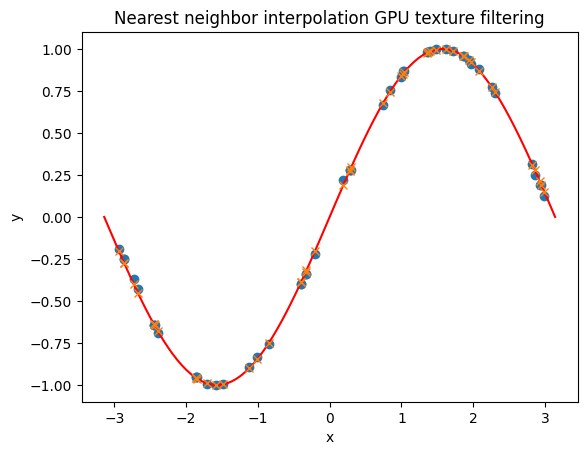

In [ ]:
N         = 100                                                   # --- Number of input points
M         = 50                                                    # --- Number of output points

##########################################
# CPU MEMORY ALLOCATIONS AND DEFINITIONS #
##########################################
xin       = np.linspace(-np.pi, np.pi, N)                         # --- Input sampling points
yin       = np.sin(xin)                                           # --- Input samples
xout      = np.pi * np.random.uniform(-1., 1., size = M)          # --- Output sampling pointsprint(len((xout)))

# --- Set CPU arrays as single precision
xin       = xin.astype(np.float32)
yin       = yin.astype(np.float32)
xout      = xout.astype(np.float32)

##########################################
# GPU MEMORY ALLOCATIONS AND DEFINITIONS #
##########################################
d_xin                         = cuda.mem_alloc(xin.nbytes)
d_yin                         = cuda.mem_alloc(yin.nbytes)
d_xout                        = cuda.mem_alloc(xout.nbytes)
d_youtLinear                  = cuda.mem_alloc(xout.nbytes)
d_youtLinearTexture           = cuda.mem_alloc(xout.nbytes)
d_youtNearestTextureFiltering = cuda.mem_alloc(xout.nbytes)
d_youtLinearTextureFiltering  = cuda.mem_alloc(xout.nbytes)

# --- Memcopy from host to device
cuda.memcpy_htod(d_xin, xin)
cuda.memcpy_htod(d_yin, yin)
cuda.memcpy_htod(d_xout, xout)

########################################
# NEAREST NEIGHBOR INTERPOLATION - CPU #
########################################
youtNearestNeighbor         = nearestNeighborInterpolation1D(xin, yin, xout)
youtNearestNeighborScyPi    = interpolate.interp1d(xin, yin, kind = 'nearest')
youtNearestNeighborRef      = youtNearestNeighborScyPi(xout)
print("Root mean square for nearest neighbor interpolation on CPU %1.6f" %(100. * np.sqrt(np.sum(np.power(np.abs(youtNearestNeighbor - youtNearestNeighborRef), 2))) / np.sum(np.power(np.abs(youtNearestNeighborRef), 2))))

plt.plot(xout, youtNearestNeighbor, 'o')
plt.plot(xin, yin, 'r')
plt.plot(xout, youtNearestNeighborRef, 'x')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Nearest neighbor interpolation')
plt.show()

##############################
# LINEAR INTERPOLATION - CPU #
##############################
youtLinear                  = linearInterpolation1D(xin, yin, xout)
youtNearestLinearScyPi      = interpolate.interp1d(xin, yin, kind = 'linear')
youtNearestLinearRef        = youtNearestLinearScyPi(xout)
print("Root mean square for linear interpolation on CPU %1.6f" %(100. * np.sqrt(np.sum(np.power(np.abs(youtLinear - youtNearestLinearRef), 2))) / np.sum(np.power(np.abs(youtNearestLinearRef), 2))))

plt.plot(xout, youtLinear, 'o')
plt.plot(xin, yin, 'r')
plt.plot(xout, youtNearestLinearRef, 'x')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear interpolation CPU')
plt.show()

##############################
# LINEAR INTERPOLATION - GPU #
##############################
ndx                         = np.float32(1) / (xin[1] - xin[0])
linear_interpolation_function_GPU(d_xin, d_yin, d_xout, d_youtLinear, ndx, N, M)

h_youtLinear               = np.empty_like(youtLinear)
cuda.memcpy_dtoh(h_youtLinear, d_youtLinear)
print("Root mean square for linear interpolation on GPU %1.6f" %(100. * np.sqrt(np.sum(np.power(np.abs(h_youtLinear - youtNearestLinearRef), 2))) / np.sum(np.power(np.abs(youtNearestLinearRef), 2))))

plt.plot(xout, h_youtLinear, 'o')
plt.plot(xin, yin, 'r')
plt.plot(xout, youtNearestLinearRef, 'x')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear interpolation GPU')
plt.show()

################################################
# LINEAR INTERPOLATION - GPU - TEXTURE READOUT #
################################################
# --- Definition of a gpuarray to be bounded to the texture object
yin           = np.reshape(yin, (yin.size, 1))
d_yin_for_tex = gpuarray.to_gpu(yin)

linear_interpolation_function_GPU_texture(d_xin, d_yin_for_tex, d_xout, d_youtLinearTexture, ndx, N, M)

h_youtLinearTexture         = np.empty_like(youtLinear)
cuda.memcpy_dtoh(h_youtLinearTexture, d_youtLinearTexture)
print("Root mean square for linear interpolation on GPU (texture) %1.6f" %(100. * np.sqrt(np.sum(np.power(np.abs(h_youtLinearTexture - youtNearestLinearRef), 2))) / np.sum(np.power(np.abs(youtNearestLinearRef), 2))))

plt.plot(xout, h_youtLinearTexture, 'o')
plt.plot(xin, yin, 'r')
plt.plot(xout, youtNearestLinearRef, 'x')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear interpolation GPU texture filtering')
plt.show()

##################################################
# LINEAR INTERPOLATION - GPU - TEXTURE FILTERING #
##################################################
# --- Definition of a gpuarray to be bounded to the texture object

yin2          = np.array(yin, dtype = np.float32).reshape(1, yin.size)

linear_interpolation_function_GPU_texture_filtering(d_xin, yin2, d_xout, d_youtLinearTextureFiltering, ndx, N, M)

h_youtLinearTextureFiltering  = np.empty_like(youtNearestLinearRef)
cuda.memcpy_dtoh(h_youtLinearTextureFiltering, d_youtLinearTextureFiltering)
print("Root mean square for linear interpolation on GPU (texture) %1.6f" %(100. * np.sqrt(np.sum(np.power(np.abs(h_youtLinearTextureFiltering - youtNearestLinearRef), 2))) / np.sum(np.power(np.abs(youtNearestLinearRef), 2))))

plt.plot(xout, h_youtLinearTextureFiltering, 'o')
plt.plot(xin, yin, 'r')
plt.plot(xout, youtNearestLinearRef, 'x')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear interpolation GPU texture filtering')
plt.show()

############################################################
# NEAREST NEIGHBOR INTERPOLATION - GPU - TEXTURE FILTERING #
############################################################
# --- Definition of a gpuarray to be bounded to the texture object

yin2          = np.array(yin, dtype = np.float32).reshape(1, yin.size)

nearest_interpolation_function_GPU_texture_filtering(d_xin, yin2, d_xout, d_youtNearestTextureFiltering, ndx, N, M)

h_youtNearestTextureFiltering  = np.empty_like(youtNearestLinearRef)
cuda.memcpy_dtoh(h_youtNearestTextureFiltering, d_youtNearestTextureFiltering)
print("Root mean square for linear interpolation on GPU (texture) %1.6f" %(100. * np.sqrt(np.sum(np.power(np.abs(h_youtNearestTextureFiltering - youtNearestLinearRef), 2))) / np.sum(np.power(np.abs(youtNearestLinearRef), 2))))

plt.plot(xout, h_youtNearestTextureFiltering, 'o')
plt.plot(xin, yin, 'r')
plt.plot(xout, youtNearestLinearRef, 'x')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Nearest neighbor interpolation GPU texture filtering')
plt.show()